# Lecture 15 Support Vector Machine (SVM)

Course materials of this lecture is largely from https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

Let's start from an example:

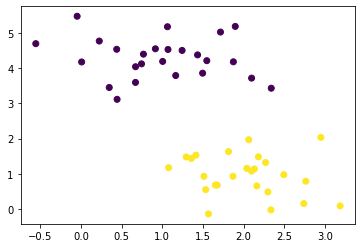

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y = make_blobs(n_samples = 50, centers = 2, random_state=0, cluster_std = 0.6)

plt.scatter(X[:,0], X[:,1], c=y)

#### Now our problem is: can we find a straight line that can separate the data into two clusters?
The line is a model for classification.

We can draw many lines that can meet the requirement of "separating the data into two clusters":

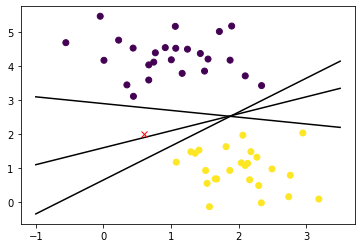

In [2]:
import numpy as np

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y)

for m,b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m*xfit+b, 'k-')
    
plt.plot(0.6, 2, 'rx')

Each of the three lines meets our requirement. But if we have a new data point, indicated by the red x, it will be classified into different catergories.

#### That suggests:  we should put additional constraints on the requirement of the classification line.

If we define 'margin' as the distance from the line to the nearest point,

#### The problem becomes: the line that maximize the Margin is the one we want as the optimal model. 
#### The algorithm to find the line with maximum margin is support vector machine (SVM).

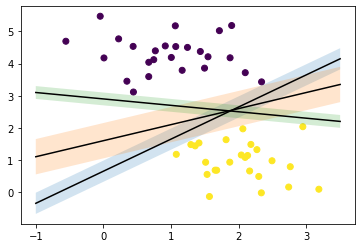

In [3]:
import numpy as np

xfit = np.linspace(-1, 3.5)
plt.scatter(X[:,0], X[:,1], c=y)

for m,b,d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m*xfit+b
    plt.plot(xfit, yfit, 'k-')
    plt.fill_between(xfit, yfit-d, yfit+d, edgecolor='none', alpha=0.2)

In [4]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [5]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, edgecolors='k', facecolors='none');

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

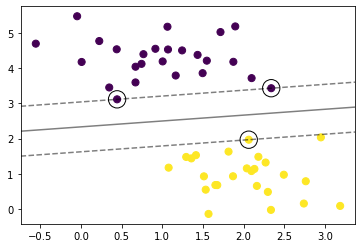

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(model)
model.support_vectors_

A few of the training points just touch the margin: they are indicated by the black circles in this figure. 
#### These points are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name.

Only the position of the support vectors matter the fit of the separating line, and any points further from the margin which are on the correct side do not modify the fit, because because these points do not contribute to the loss function used to fit the model.

In [7]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
from ipywidgets import interact, fixed
interact(plot_svm, N=np.arange(10,200,10), ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 13…

Now let's take a look at another example. Can we use a line to separate the two groups of data?

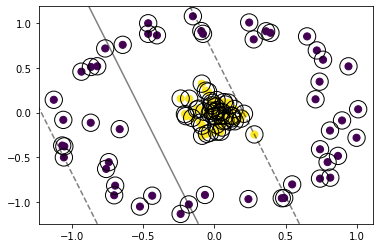

In [8]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf, plot_support=True);

It is clear that no linear discrimination will ever be able to separate this data. But we can think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

In [9]:
r = np.exp(-(X ** 2).sum(1))

from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('r')

interact(plot_3D, elev=np.arange(-90,91,30), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', index=4, options=(-90, -60, -30, 0, 30, 60, 90), value=30),…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

### Kernel
Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a kernel transformation, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting N points into N dimensions—is that it might become very computationally intensive as N grows large - use the kernel trick!

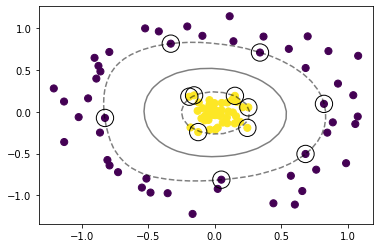

In [10]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='rbf').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf, plot_support=True);

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

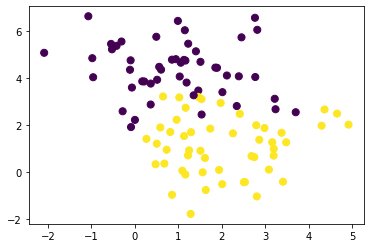

In [11]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

We can "softens" the margin: allows some of the points to creep into the margin if that allows a better fit. 

The parameter C controls the hardness the margin.
The larger C is, the harder the margin is.

Text(0.5, 1.0, 'C = 10000000.0')

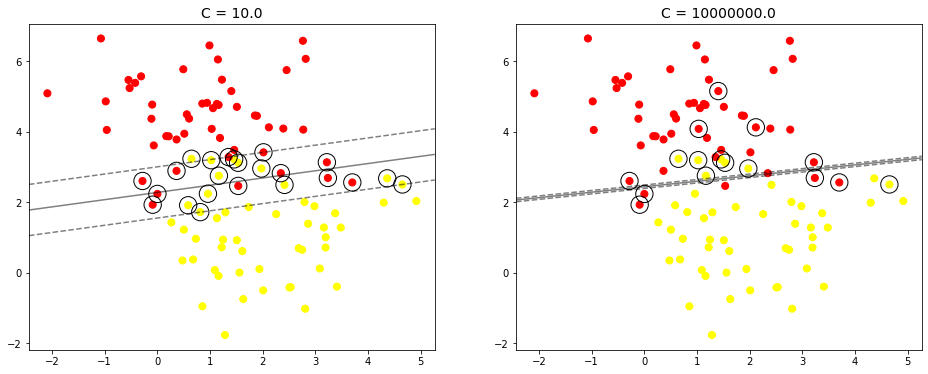

In [12]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

i = 0
C = 10
model = SVC(kernel='linear', C=C).fit(X, y)
ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax[i])
ax[i].scatter(model.support_vectors_[:, 0],
model.support_vectors_[:, 1],
s=300, lw=1, facecolors='none');
ax[i].set_title('C = {0:.1f}'.format(C), size=14)

i = 1
C = 10000000
model = SVC(kernel='linear', C=C).fit(X, y)
ax[i].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax[i])
ax[i].scatter(model.support_vectors_[:, 0],
model.support_vectors_[:, 1],
s=300, lw=1, facecolors='none');
ax[i].set_title('C = {0:.1f}'.format(C), size=14)

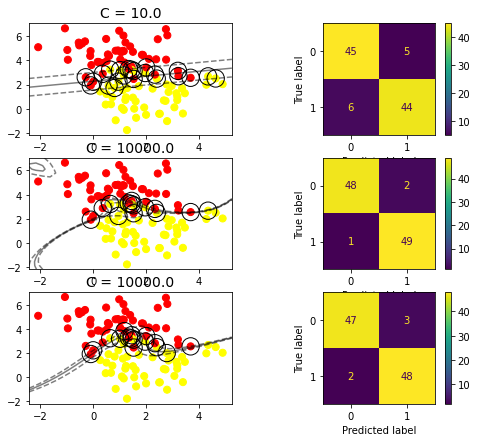

In [37]:
from sklearn.metrics import plot_confusion_matrix

X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)

fig, ax = plt.subplots(3, 2, figsize=(8, 7))

i = 0
C = 10
model = SVC(kernel='linear', C=C).fit(X, y)
ax[i,0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax[i,0])
ax[i,0].scatter(model.support_vectors_[:, 0],
model.support_vectors_[:, 1],
s=300, lw=1, facecolors='none');
ax[i,0].set_title('C = {0:.1f}'.format(C), size=14)

plot_confusion_matrix(model, X, y, ax=ax[i,1])


# use a rbf kernel
i = 1
C = 10000
model = SVC(kernel='rbf', C=C).fit(X, y)
ax[i,0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax[i,0])
ax[i,0].scatter(model.support_vectors_[:, 0],
model.support_vectors_[:, 1],
s=300, lw=1, facecolors='none');
ax[i,0].set_title('C = {0:.1f}'.format(C), size=14)
plot_confusion_matrix(model, X, y, ax=ax[i,1])

# use a poly kernel
i = 2
C = 10000
model = SVC(kernel='poly', C=C).fit(X, y)
ax[i,0].scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax[i,0])
ax[i,0].scatter(model.support_vectors_[:, 0],
model.support_vectors_[:, 1],
s=300, lw=1, facecolors='none');
ax[i,0].set_title('C = {0:.1f}'.format(C), size=14)
plot_confusion_matrix(model, X, y, ax=ax[i,1])

### Math behind the algorithm

See Section 3.4 in Chapter 3 in the 100-page machine learning book.